<a href="https://colab.research.google.com/github/ArifAygun/CustomerEye/blob/main/Company_Reviews(1_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **IMPORT LIBRARIES AND DATASET**

In [104]:
!pip install pycountry

In [105]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator
import pycountry

from google.colab import drive

In [106]:
# Mount Google Drive
drive.mount('/content/drive/')

# Change directory to the analysis folder
%cd /content/drive/My Drive/Analysis_1/

# Read CSV files into DataFrames
df1 = pd.read_csv('Freedom_Debt_Relief.csv')
df2 = pd.read_csv('Millennium_Trust.csv')
df3 = pd.read_csv('Advance_America.csv')

print(df1.info(), df1.head())
print(df2.info(), df2.head())
print(df3.info(), df3.head())

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Analysis_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39078 entries, 0 to 39077
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Reviewer Name    39068 non-null  object
 1   Reviews Count    39078 non-null  object
 2   Country Code     39078 non-null  object
 3   Experience Date  39078 non-null  object
 4   Rating           39078 non-null  int64 
 5   Review Date      39078 non-null  object
 6   Review Title     39074 non-null  object
 7   Review Text      34241 non-null  object
 8   Reply Date       37731 non-null  object
 9   Reply Text       37731 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.0+ MB
None     Reviewer Name Reviews Count Country Code    Experience Date  Rating  \
0  Andrea Sciotti      2reviews           US  December 

### **DATA PREPROCESSING**

In [107]:
# Function for preprocessing
def preprocessing(df, reply_text):
    # Convert 'Reviews Count' to integers
    df['Reviews Count'] = df['Reviews Count'].str.extract('(\d+)').astype(int)

    # Replace the specified text in 'Reply Date' column
    df['Reply Date'] = df['Reply Date'].str.replace(reply_text, '').str.strip()

    # Convert 'Experience Date', 'Review Date', and 'Reply Date' to datetime
    date_columns = ['Experience Date', 'Review Date', 'Reply Date']
    df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')

    # Extract 'Year' from 'Review Date' and create a new column
    df['Year'] = df['Review Date'].dt.year

    # Drop rows with NaN values in 'Experience Date', 'Review Date', or 'Reply Date'
    df = df.dropna(subset=date_columns)

    # Create a copy to avoid SettingWithCopyWarning
    df = df.copy()

    # Concatenate 'Review Title' and 'Review Text' into a new 'Reviews' column
    df.loc[:, 'Reviews'] = df['Review Title'].astype(str) + ' ' + df['Review Text'].astype(str)

    # Rename 'Reply Text' column to 'Replies'
    df = df.rename(columns={'Reply Text': 'Replies', 'Country Code': 'Country'})

    # Add a new column with country names
    df['Countries'] = df['Country'].apply(lambda code: pycountry.countries.get(alpha_2=code).name if pycountry.countries.get(alpha_2=code) else None)

    # Calculate response time between 'Experience Date' and 'Review Date' in days
    df['Exp to Review'] = (df['Review Date'] - df['Experience Date']).dt.total_seconds() / 86400

    # Calculate response time between 'Review Date' and 'Reply Date' in days
    df['Review to Reply'] = (df['Reply Date'] - df['Review Date']).dt.total_seconds() / 86400

    # Round the values to the nearest integer and convert to int
    df[['Exp to Review', 'Review to Reply']] = df[['Exp to Review', 'Review to Reply']].round(0).astype(int)

    # Drop the original 'Review Title' and 'Review Text' columns
    df = df.drop(['Reviewer Name', 'Reviews Count', 'Review Title', 'Review Text','Country'], axis=1)

    # Rearrange the columns
    df = df[['Year', 'Experience Date', 'Review Date', 'Reply Date','Exp to Review',
             'Review to Reply','Rating', 'Countries', 'Reviews', 'Replies']]

    return df

# Calculate response time for each DataFrame
df1 = preprocessing(df1, 'Reply from Freedom Debt Relief')
df2 = preprocessing(df2, 'Reply from Millennium Trust')
df3 = preprocessing(df3, 'Reply from Advance America')

# Print the updated DataFrame information
pd.set_option('display.max_columns', None)

print(df1.info())
print(df2.info())
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36713 entries, 0 to 39077
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Year             36713 non-null  float64       
 1   Experience Date  36713 non-null  datetime64[ns]
 2   Review Date      36713 non-null  datetime64[ns]
 3   Reply Date       36713 non-null  datetime64[ns]
 4   Exp to Review    36713 non-null  int64         
 5   Review to Reply  36713 non-null  int64         
 6   Rating           36713 non-null  int64         
 7   Countries        36713 non-null  object        
 8   Reviews          36713 non-null  object        
 9   Replies          36713 non-null  object        
dtypes: datetime64[ns](3), float64(1), int64(3), object(3)
memory usage: 3.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29374 entries, 235 to 39327
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  

### **DATA SAMPLING**

In [108]:
# Function for random sampling
def perform_sampling(df):
    years_to_keep = [2021, 2022, 2023]

    # Filter data for the specified years
    filtered_df = df[df['Review Date'].dt.year.isin(years_to_keep)]

    # Count the occurrences of each rating for each year
    yearly_rating_counts = filtered_df.groupby(['Year', 'Rating']).size().unstack(fill_value=0)

    # Perform random sampling to get 2000 datapoints
    sampled_df = pd.DataFrame()
    for year in years_to_keep:
        year_data = filtered_df[filtered_df['Review Date'].dt.year == year]
        sampled_data = year_data.sample(n=2000, replace=True)  # Adjust the sampling size as needed
        sampled_df = pd.concat([sampled_df, sampled_data])

    return sampled_df

# Apply sampling for each dataset
sampled_df1 = perform_sampling(df1)
sampled_df2 = perform_sampling(df2)
sampled_df3 = perform_sampling(df3)

# Ensure all sampled dataframes have the same number of datapoints (2000)
sampled_df1 = sampled_df1.sample(n=2000, replace=True)
sampled_df2 = sampled_df2.sample(n=2000, replace=True)
sampled_df3 = sampled_df3.sample(n=2000, replace=True)

print(sampled_df1.info())
print(sampled_df2.info())
print(sampled_df3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 8594 to 35928
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Year             2000 non-null   float64       
 1   Experience Date  2000 non-null   datetime64[ns]
 2   Review Date      2000 non-null   datetime64[ns]
 3   Reply Date       2000 non-null   datetime64[ns]
 4   Exp to Review    2000 non-null   int64         
 5   Review to Reply  2000 non-null   int64         
 6   Rating           2000 non-null   int64         
 7   Countries        2000 non-null   object        
 8   Reviews          2000 non-null   object        
 9   Replies          2000 non-null   object        
dtypes: datetime64[ns](3), float64(1), int64(3), object(3)
memory usage: 171.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 23467 to 12664
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         


## **EDA**

### TOTAL RATINGS OVER YEARS

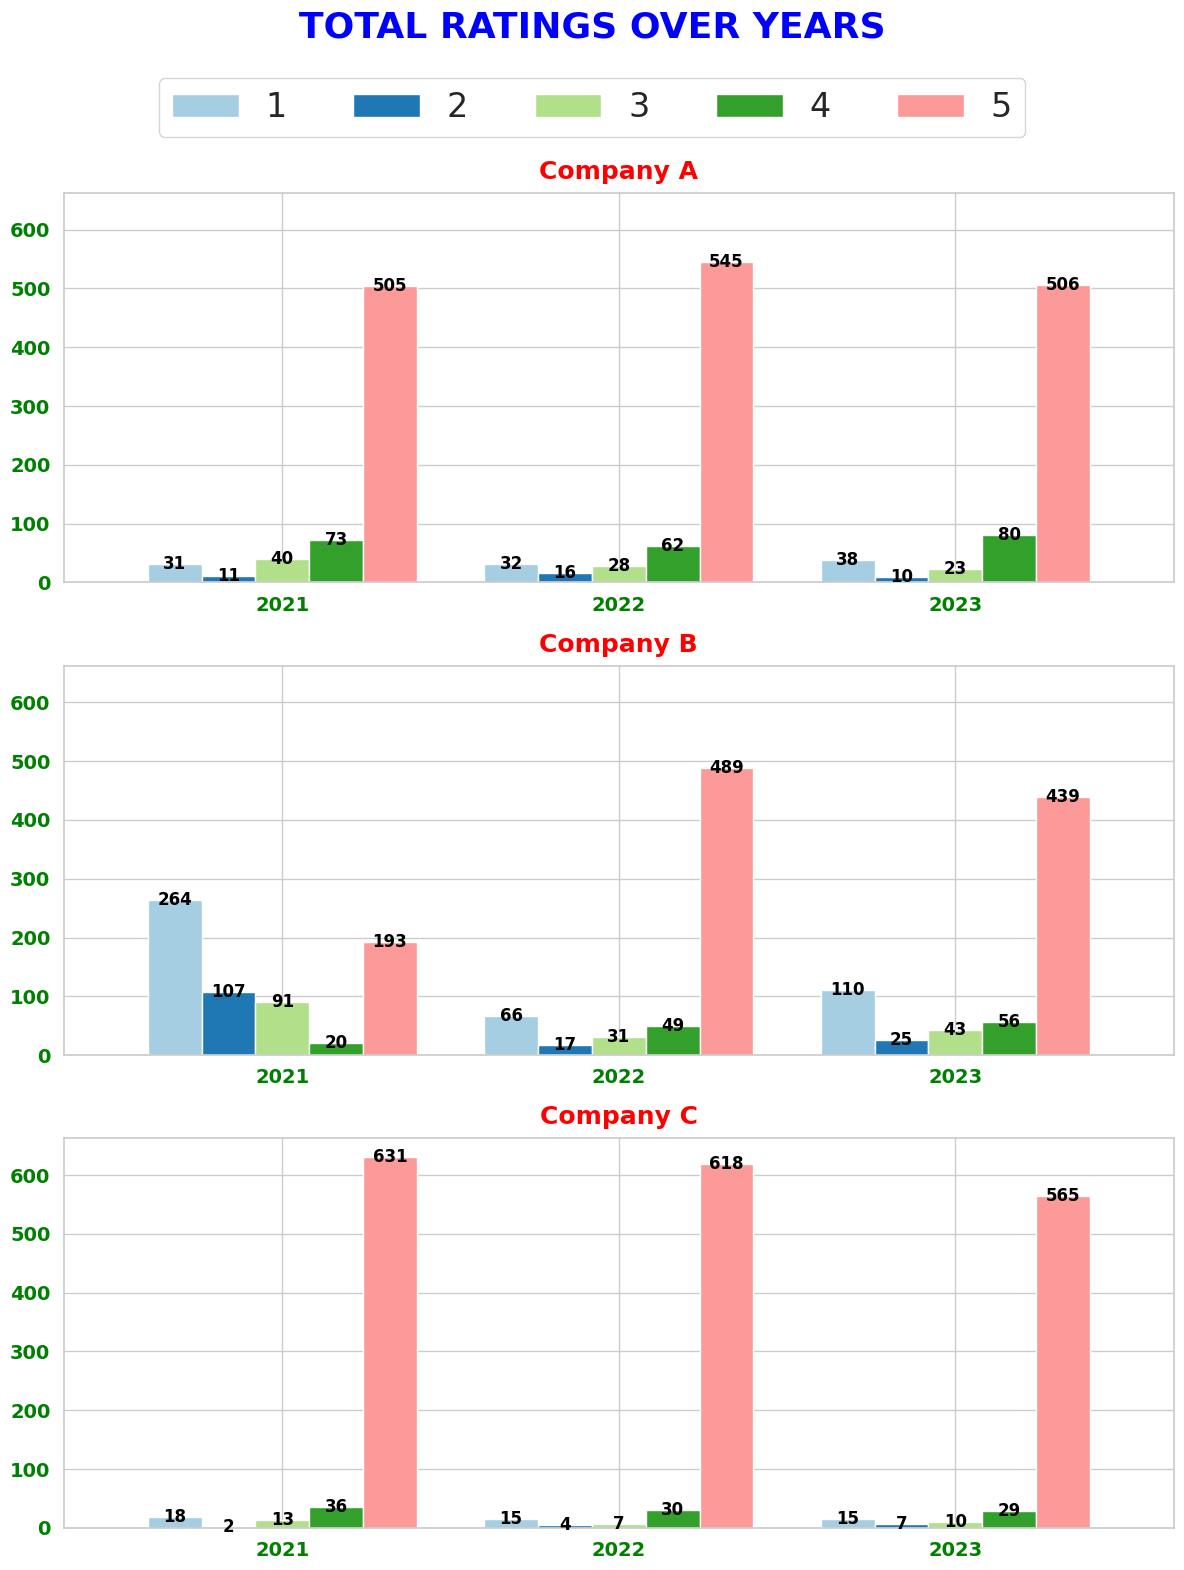

In [109]:
# Assuming sampled_df1, sampled_df2, and sampled_df3 are your three DataFrames

# Create a figure with three subplots for vertical side-by-side bar charts
fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharey=True)

# Set Seaborn color palette to "Paired"
sns.set_palette("Paired")

# Lists to collect handles and labels for the legend
handles = []
labels = set()  # Using a set to avoid duplicates in labels

# Plot vertical side-by-side bars for each rating for each DataFrame
for i, df in enumerate([sampled_df1, sampled_df2, sampled_df3]):
    yearly_rating_counts = df.groupby(['Year', 'Rating']).size().unstack(fill_value=0)

    # Cast the years to integers
    yearly_rating_counts.index = yearly_rating_counts.index.astype(int)

    # Create side-by-side bar plot
    plot = yearly_rating_counts.plot(kind='bar', stacked=False, ax=axes[i], legend=False, width=0.8)

    # Collect handles and labels for the legend
    plot_handles, plot_labels = axes[i].get_legend_handles_labels()
    handles.extend(plot_handles)

    # Use set union to add unique labels to the set
    labels |= set(plot_labels)

    # Set labels and title for each subplot
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(f'Company {chr(ord("A") + i)}', fontsize=18, color='red', fontweight='bold', pad=10)  # Adjust the 'pad' value as needed

    # Remove decimals in the x-axis labels
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Rotate x-axis labels to be horizontal
    plt.setp(axes[i].get_xticklabels(), rotation=0, ha="center", fontsize=14, fontweight='bold', color='green')

    # Make y-axis labels bold and set font size using FixedLocator and FixedFormatter
    yticks = [int(ytick) for ytick in axes[i].get_yticks()]
    axes[i].yaxis.set_major_locator(FixedLocator(yticks))
    axes[i].set_yticklabels(yticks, fontsize=14, fontweight='bold', color='green')

    # Annotate each bar with the corresponding rating values above the bars
    for bar in plot.patches:
        axes[i].annotate(f'{bar.get_height():.0f}',
                         (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                         ha='center', va='center', fontsize=12, color='black', fontweight='bold')

# Sort labels in ascending order
sorted_labels = sorted(labels, key=lambda x: int(x))

# Create a combined legend for all plots horizontally with adjusted parameters
legend = fig.legend(handles, sorted_labels, loc='lower center', bbox_to_anchor=(0.5, 0.91), ncol=5, borderaxespad=0.5, prop={'size': 24})

# Set legend title font size
legend.get_title().set_fontsize(14)

# Set a general title for the entire subplot
fig.suptitle('TOTAL RATINGS OVER YEARS', fontsize=26, color='blue', fontweight='bold', y=1)

# Adjust layout
plt.tight_layout(rect=[0, 0.02, 1, 0.95])

# Show the vertical side-by-side bar charts with a single legend at the bottom
plt.show()


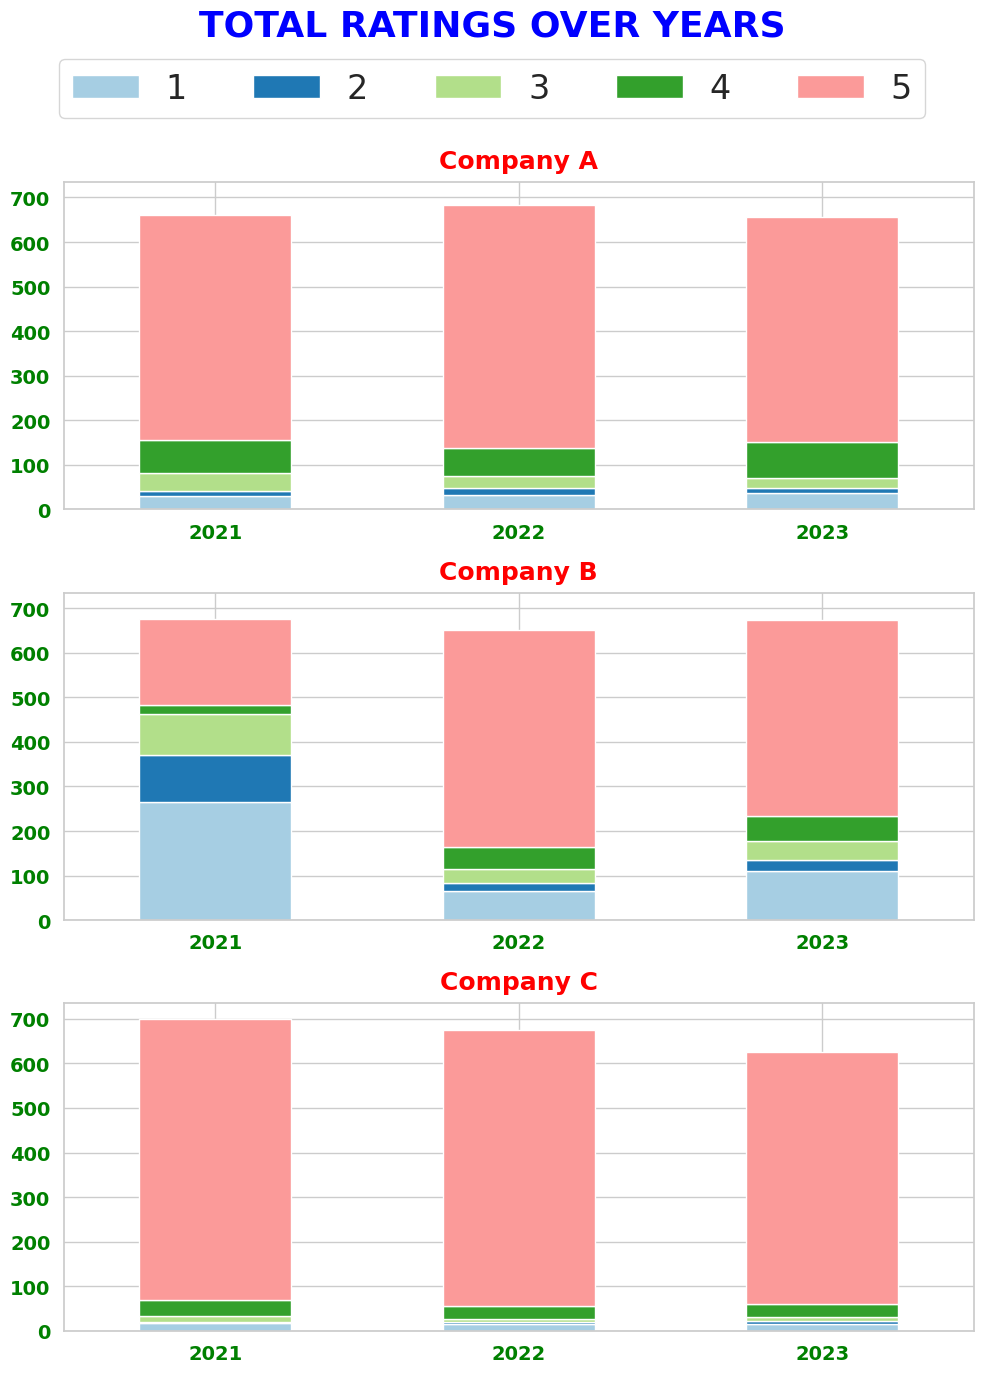

In [110]:
# Create a figure with three subplots for vertical stacked bar charts
fig, axes = plt.subplots(3, 1, figsize=(10, 14), sharey=True)

# Set Seaborn color palette to "Paired"
sns.set_palette("Paired")

# Lists to collect handles and labels for the legend
handles = []
labels = set()  # Using a set to avoid duplicates in labels

# Plot vertical stacked bars for each rating for each DataFrame
for i, df in enumerate([sampled_df1, sampled_df2, sampled_df3]):
    yearly_rating_counts = df.groupby(['Year', 'Rating']).size().unstack(fill_value=0)

    # Cast the years to integers
    yearly_rating_counts.index = yearly_rating_counts.index.astype(int)

    plot = yearly_rating_counts.plot(kind='bar', stacked=True, ax=axes[i], legend=False)

    # Collect handles and labels for the legend
    plot_handles, plot_labels = axes[i].get_legend_handles_labels()
    handles.extend(plot_handles)

    # Use set union to add unique labels to the set
    labels |= set(plot_labels)

    # Set labels and title for each subplot
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(f'Company {chr(ord("A") + i)}', fontsize=18, color='red', fontweight='bold', pad=10)  # Adjust the 'pad' value as needed

    # Remove decimals in the x-axis labels
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Rotate x-axis labels to be horizontal
    plt.setp(axes[i].get_xticklabels(), rotation=0, ha="center", fontsize=14, fontweight='bold', color='green')

    # Make y-axis labels bold and set font size using FixedLocator and FixedFormatter
    yticks = [int(ytick) for ytick in axes[i].get_yticks()]
    axes[i].yaxis.set_major_locator(FixedLocator(yticks))
    axes[i].set_yticklabels(yticks, fontsize=14, fontweight='bold', color='green')

# Sort labels in ascending order
sorted_labels = sorted(labels, key=lambda x: int(x))

# Create a combined legend for all plots horizontally with adjusted parameters
legend = fig.legend(handles, sorted_labels, loc='lower center', bbox_to_anchor=(0.5, 0.91), ncol=5, borderaxespad=0.5, prop={'size': 24})

# Set legend title font size
legend.get_title().set_fontsize(14)

# Set a general title for the entire subplot
fig.suptitle('TOTAL RATINGS OVER YEARS', fontsize=26, color='blue', fontweight='bold', y=1)

# Adjust layout
plt.tight_layout(rect=[0, 0.02, 1, 0.95])

# Show the vertical stacked bar charts with a single legend at the bottom
plt.show()

### MEAN RATINGS OVER YEARS

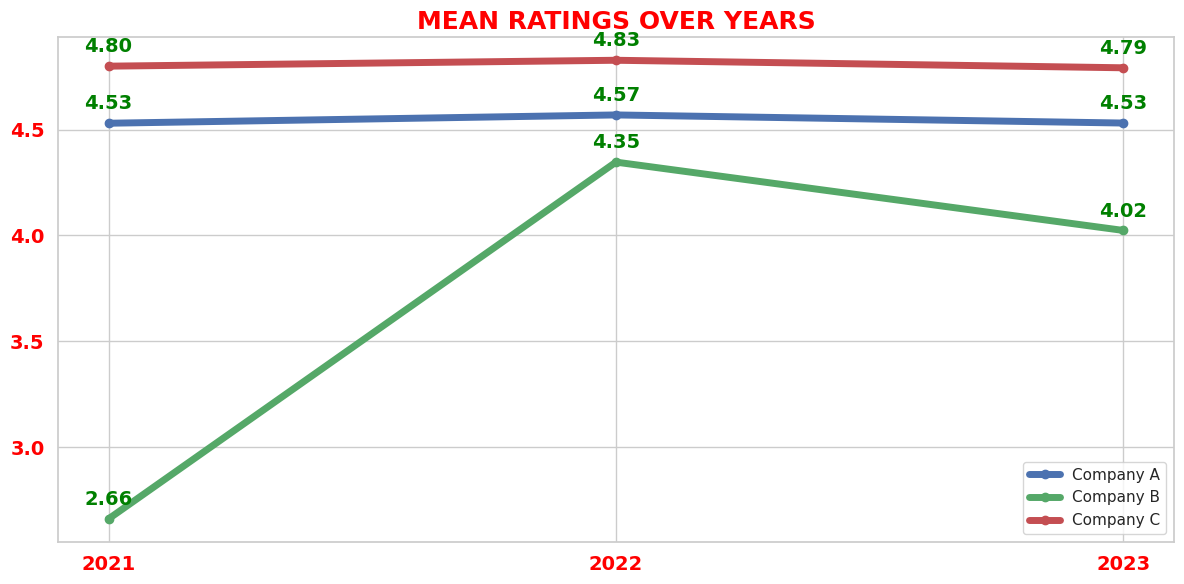

In [111]:
# Create a function to calculate the mean rating by year and plot the results
def plot_mean_rating_by_year(df, company_name, color, linewidth=2.5):
    mean_rating_by_year = df.groupby(df['Review Date'].dt.year)['Rating'].mean()

    # Create a plot for the mean rating by year
    plt.plot(mean_rating_by_year.index, mean_rating_by_year.values, marker='o', linestyle='-', label=company_name, color=color, linewidth=linewidth)

    # Annotate data points in the yearly plot with custom labels
    for x, y in zip(mean_rating_by_year.index, mean_rating_by_year.values):
        plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=14, fontweight='bold', color='green')

# Plot mean rating by year for each company
plt.figure(figsize=(12, 6))

# Modify the following lines for each company
plot_mean_rating_by_year(sampled_df1, 'Company A', 'b', linewidth=5.0)
plot_mean_rating_by_year(sampled_df2, 'Company B', 'g', linewidth=5.0)
plot_mean_rating_by_year(sampled_df3, 'Company C', 'r', linewidth=5.0)

# Customize the x-axis ticks
plt.xticks([2021, 2022, 2023], fontsize=14, fontweight='bold', color='red')

# Customize the y-axis ticks
plt.yticks(fontsize=14, fontweight='bold', color='red')

# Customize the plot
plt.title('MEAN RATINGS OVER YEARS', fontsize=18, fontweight='bold', color='red')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


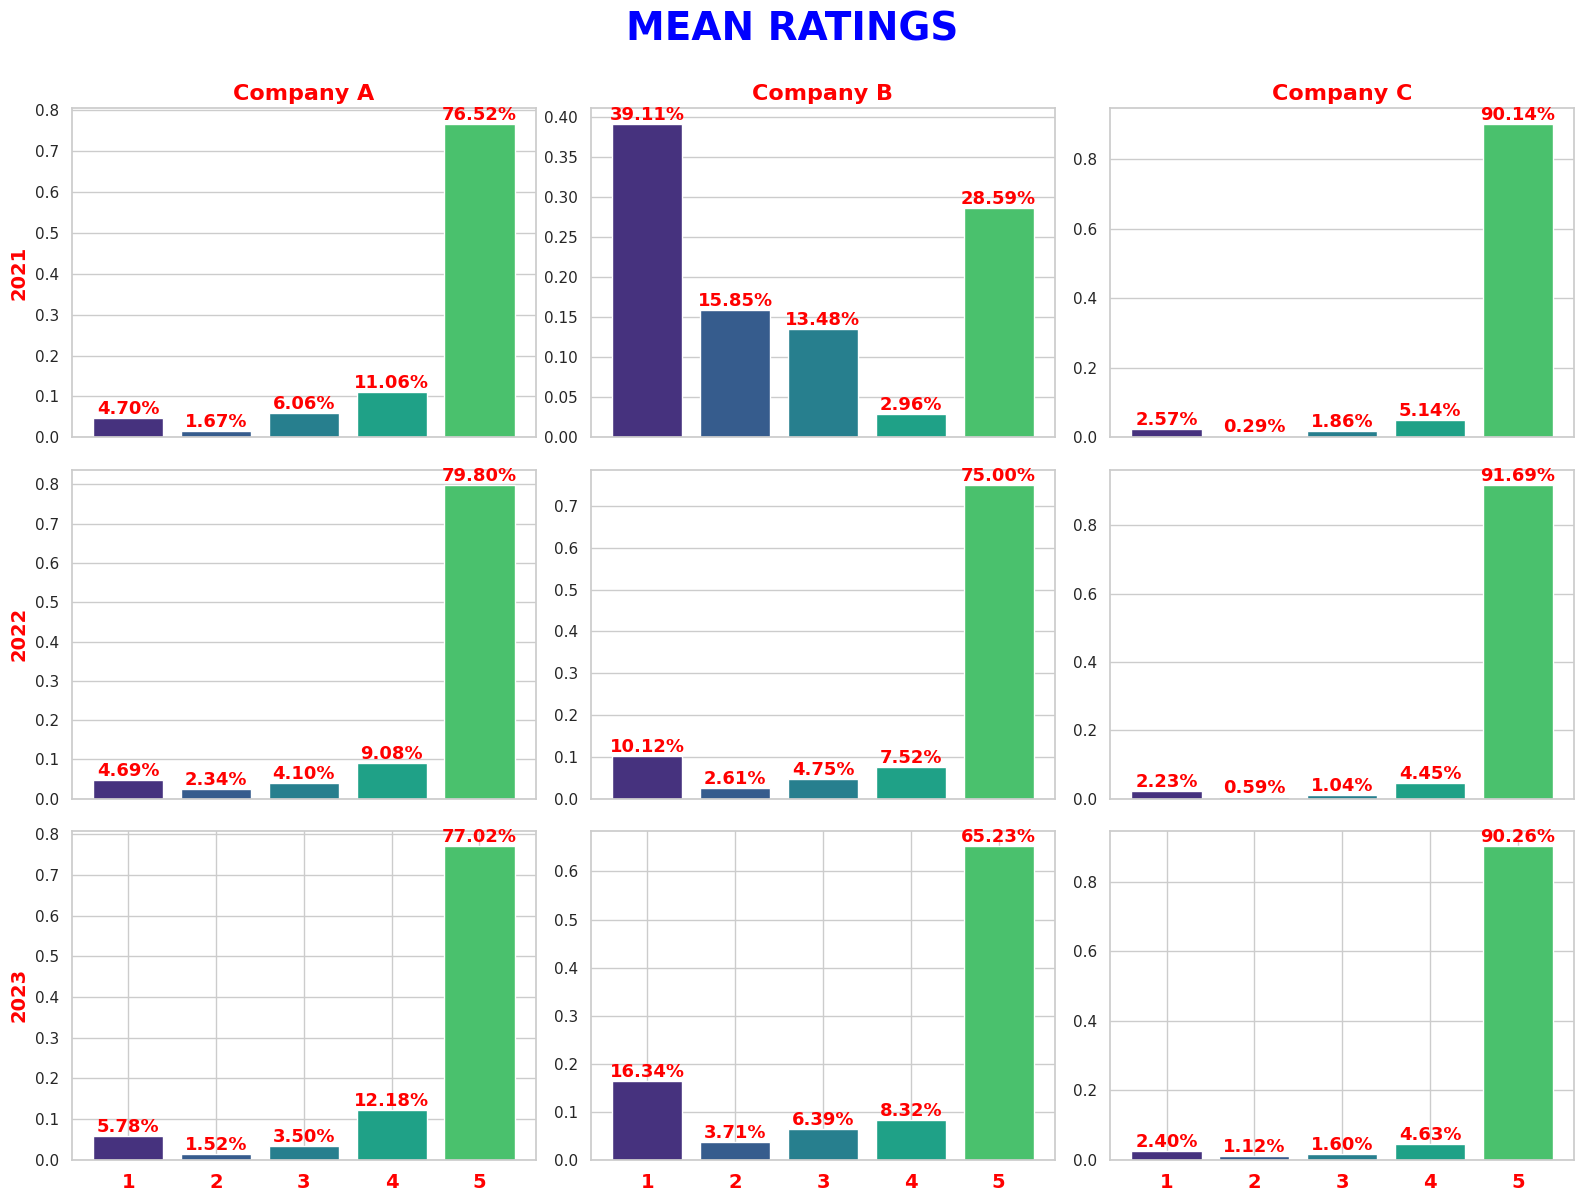

In [119]:
# Plot bar charts for mean ratings for each company and year
plt.figure(figsize=(16, 12))

# General title for the entire subplot
general_title = 'MEAN RATINGS'

for i, company_df in enumerate(companies):
    for j, year in enumerate(years):
        company_year = company_df[company_df['Year'] == year]
        mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

        # Plot the bar chart
        subplot_index = j * len(companies) + i + 1
        ax = plt.subplot(len(years), len(companies), subplot_index)

        # Manually set xticks for the last row
        bars = plt.bar(mean_ratings.index, mean_ratings.values, color=sns.color_palette("viridis"))

        # Set xticks for the last row
        if j == len(years) - 1:
            plt.xticks(ticks=mean_ratings.index, labels=mean_ratings.index.astype(str), fontsize=14, fontweight='bold', color='red')
        else:
            plt.xticks([])

        # Add labels
        if j == 0:
            plt.title(f'{company_names[i]}', fontsize=16, fontweight='bold', color='red')

        # Add y-axis label for the first subplot in each row
        if i == 0:
            plt.ylabel(year, fontsize=14, fontweight='bold', color='red')

        # Add bar labels with specified properties
        for bar, value in zip(bars, mean_ratings.values):
            plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=13, fontweight='bold', color='red')

# General title for the entire subplot (in blue)
plt.suptitle(general_title, fontsize=28, fontweight='bold', y=1, color='blue')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


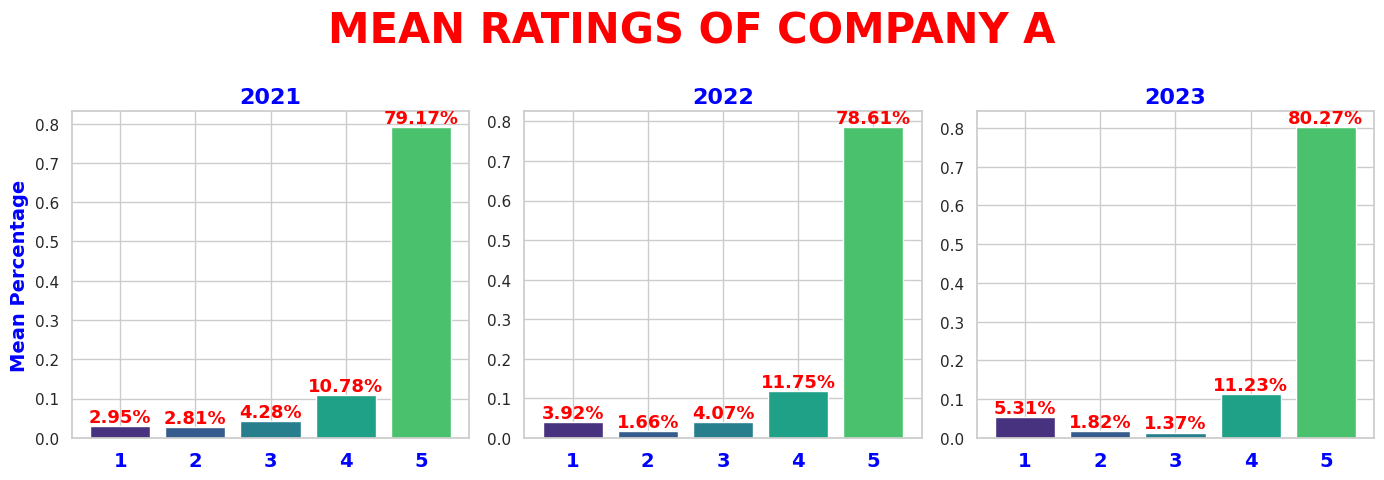

In [64]:
# Assuming sampled_df1 is your DataFrame for Company A
company_df = sampled_df1

# Define years to plot
years = [2021, 2022, 2023]

# General title for the entire subplot
general_title = 'MEAN RATINGS OF COMPANY A'

# Plot bar charts for mean ratings for Company A for each year
plt.figure(figsize=(14, 12))

for i, year in enumerate(years):
    company_year = company_df[company_df['Year'] == year]
    mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

    # Plot the bar chart
    subplot_index = i + 1
    ax = plt.subplot(3, 3, subplot_index)

    # Manually set xticks for the last row
    bars = plt.bar(mean_ratings.index, mean_ratings.values, color=sns.color_palette("viridis"))

    # Set xticks for the last row
    plt.xticks(ticks=mean_ratings.index, labels=mean_ratings.index.astype(str), fontsize=14, fontweight='bold', color='blue')

    # Add labels and title
    plt.title(f'{year}', fontsize=16, fontweight='bold', color='blue')

    # Add y-labels for the first column
    if subplot_index % 3 == 1:
        plt.ylabel('Mean Percentage', fontsize=14, fontweight='bold', color='blue')

    # Add bar labels with specified properties
    for bar, value in zip(bars, mean_ratings.values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=13, fontweight='bold', color='red')

# General title for the entire subplot
plt.suptitle(general_title, fontsize=30, fontweight='bold', y=1, color='red')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

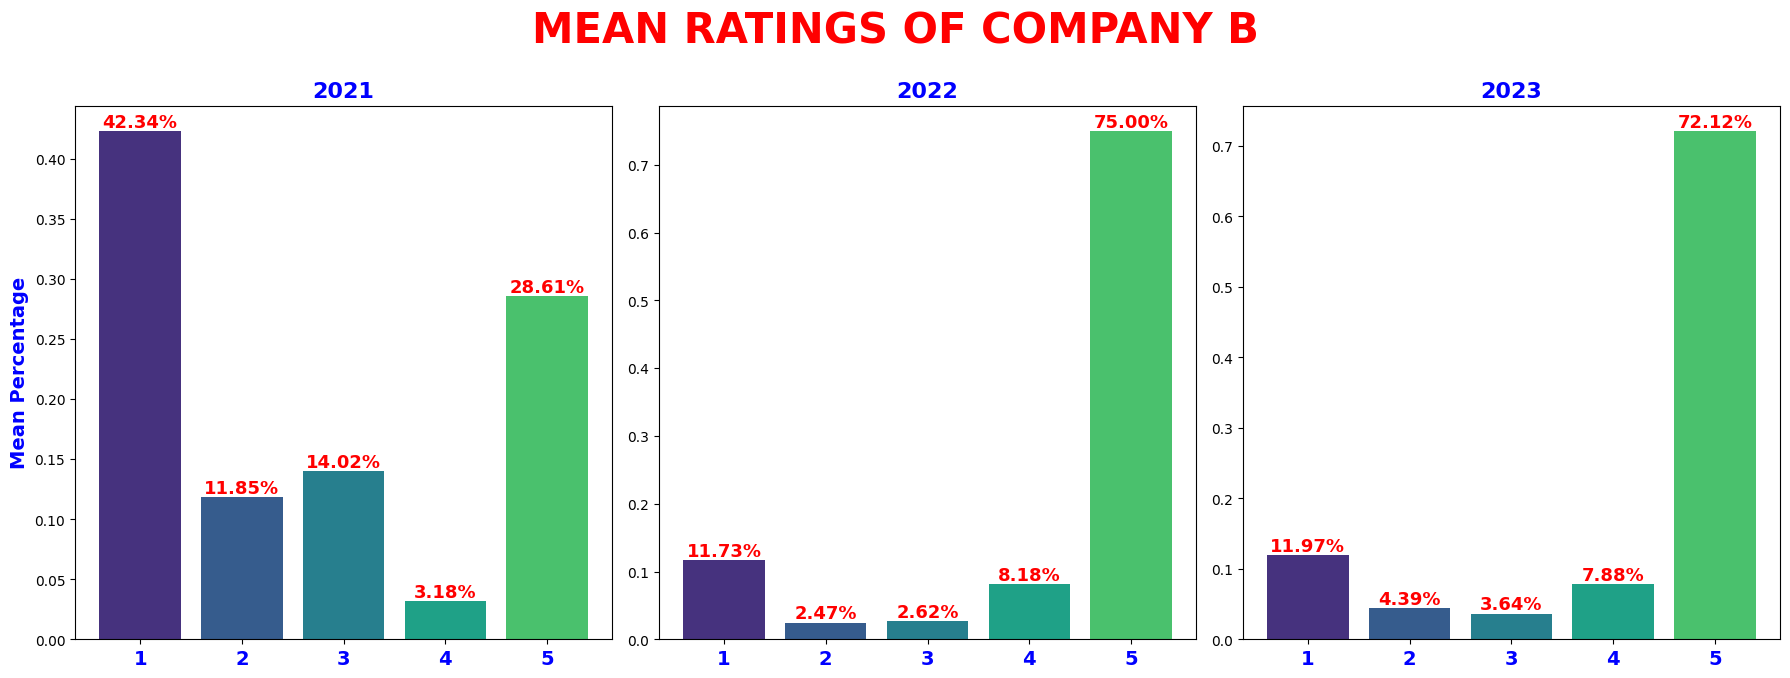

In [10]:
# Assuming sampled_df2 is your DataFrame for Company B
company_df = sampled_df2

# Define years to plot
years = [2021, 2022, 2023]

# General title for the entire subplot
general_title = 'MEAN RATINGS OF COMPANY B'

# Plot bar charts for mean ratings for Company B for each year
plt.figure(figsize=(14, 12))

for i, year in enumerate(years):
    company_year = company_df[company_df['Year'] == year]
    mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

    # Plot the bar chart
    subplot_index = i + 1
    ax = plt.subplot(3, 3, subplot_index)

    # Manually set xticks for the last row
    bars = plt.bar(mean_ratings.index, mean_ratings.values, color=sns.color_palette("viridis"))

    # Set xticks for the last row
    plt.xticks(ticks=mean_ratings.index, labels=mean_ratings.index.astype(str), fontsize=14, fontweight='bold', color='blue')

    # Add labels and title
    plt.title(f'{year}', fontsize=16, fontweight='bold', color='blue')

    # Add y-labels for the first column
    if subplot_index % 3 == 1:
        plt.ylabel('Mean Percentage', fontsize=14, fontweight='bold', color='blue')

    # Add bar labels with specified properties
    for bar, value in zip(bars, mean_ratings.values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=13, fontweight='bold', color='red')

# General title for the entire subplot
plt.suptitle(general_title, fontsize=30, fontweight='bold', y=1, color='red')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

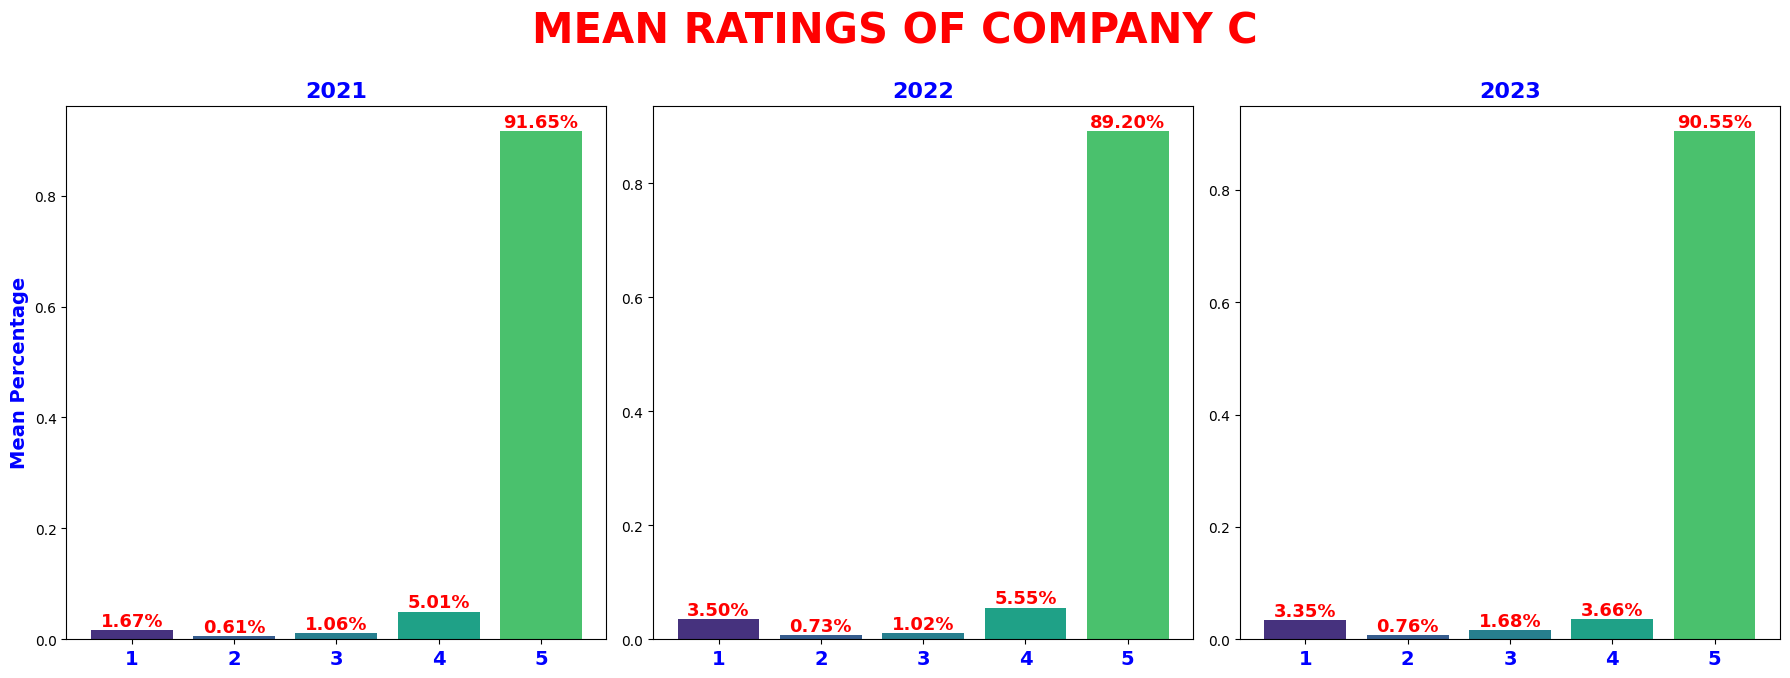

In [11]:
# Assuming sampled_df3 is your DataFrame for Company C
company_df = sampled_df3

# Define years to plot
years = [2021, 2022, 2023]

# General title for the entire subplot
general_title = 'MEAN RATINGS OF COMPANY C'

# Plot bar charts for mean ratings for Company C for each year
plt.figure(figsize=(14, 12))

for i, year in enumerate(years):
    company_year = company_df[company_df['Year'] == year]
    mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

    # Plot the bar chart
    subplot_index = i + 1
    ax = plt.subplot(3, 3, subplot_index)

    # Manually set xticks for the last row
    bars = plt.bar(mean_ratings.index, mean_ratings.values, color=sns.color_palette("viridis"))

    # Set xticks for the last row
    plt.xticks(ticks=mean_ratings.index, labels=mean_ratings.index.astype(str), fontsize=14, fontweight='bold', color='blue')

    # Add labels and title
    plt.title(f'{year}', fontsize=16, fontweight='bold', color='blue')

    # Add y-labels for the first column
    if subplot_index % 3 == 1:
        plt.ylabel('Mean Percentage', fontsize=14, fontweight='bold', color='blue')

    # Add bar labels with specified properties
    for bar, value in zip(bars, mean_ratings.values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=13, fontweight='bold', color='red')

# General title for the entire subplot
plt.suptitle(general_title, fontsize=30, fontweight='bold', y=1, color='red')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

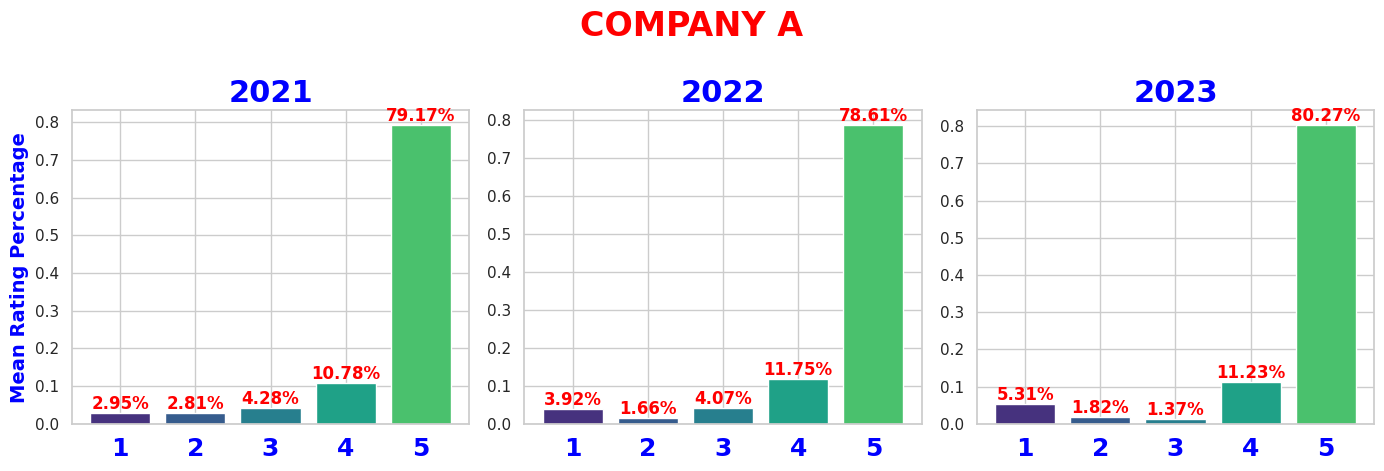

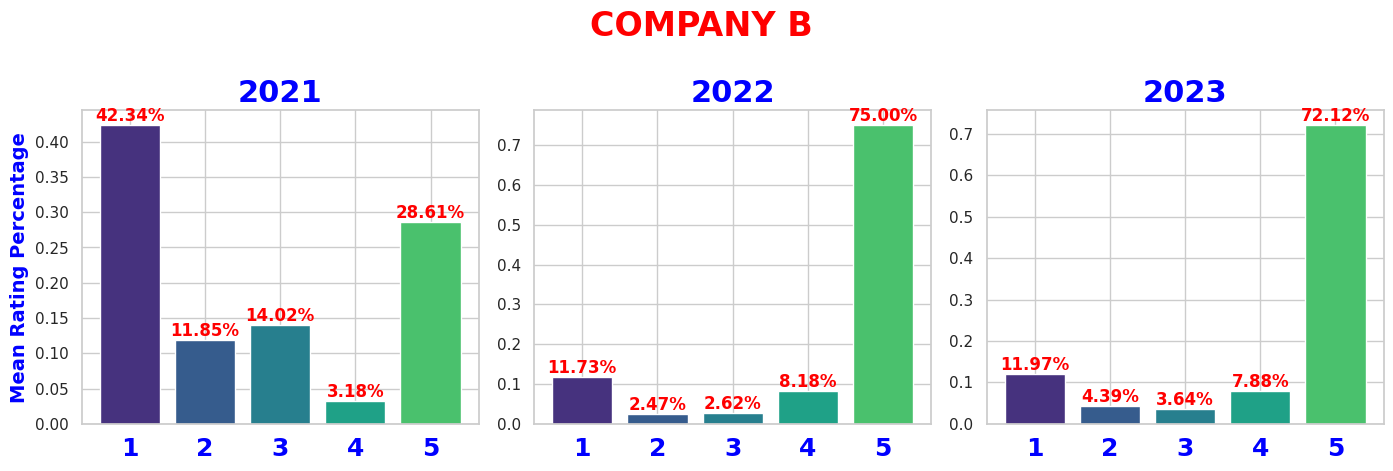

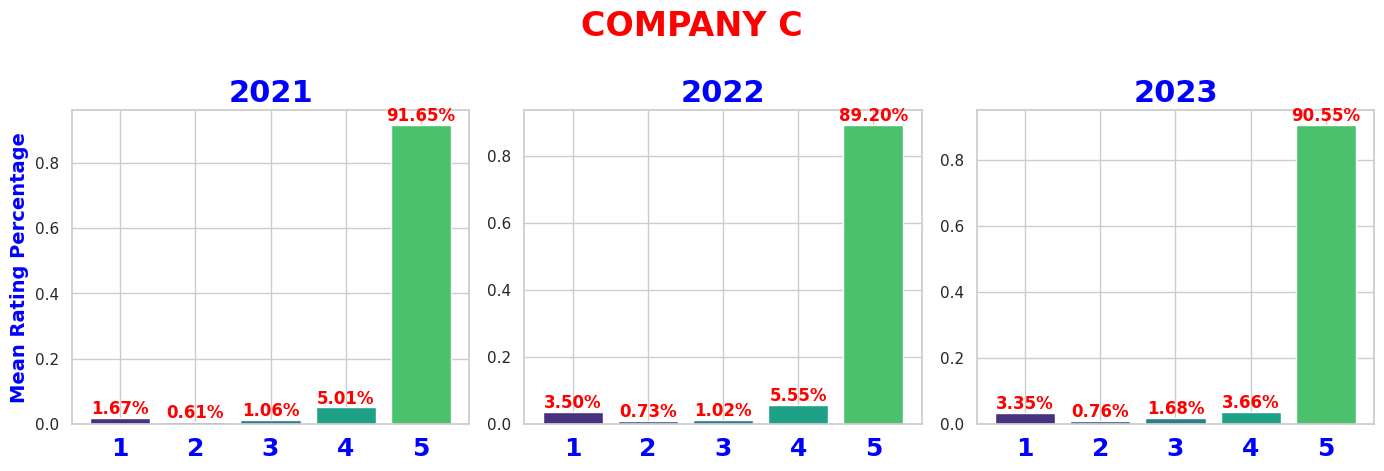

In [70]:
def plot_company_mean_ratings(company_df, company_name):
    # Define years to plot
    years = [2021, 2022, 2023]

    # General title for the entire subplot
    general_title = f'{company_name}'

    # Plot bar charts for mean ratings for the company for each year
    plt.figure(figsize=(14, 12))

    for i, year in enumerate(years):
        company_year = company_df[company_df['Year'] == year]
        mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

        # Plot the bar chart
        subplot_index = i + 1
        ax = plt.subplot(3, 3, subplot_index)

        # Manually set xticks for the last row
        bars = plt.bar(mean_ratings.index, mean_ratings.values, color=sns.color_palette("viridis"))

        # Set xticks for the last row
        plt.xticks(ticks=mean_ratings.index, labels=mean_ratings.index.astype(str), fontsize=18, fontweight='bold', color='blue')

        # Add labels and title
        plt.title(f'{year}', fontsize=22, fontweight='bold', color='blue')

        # Add y-labels for the first column
        if subplot_index % 3 == 1:
            plt.ylabel('Mean Rating Percentage', fontsize=14, fontweight='bold', color='blue')

        # Add bar labels with specified properties
        for bar, value in zip(bars, mean_ratings.values):
            plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='red')

    # General title for the entire subplot
    plt.suptitle(general_title, fontsize=24, fontweight='bold', y=1, color='red')

    # Adjust layout with a gap between subplots
    plt.tight_layout(h_pad=2)

    # Show the plot
    plt.show()

# Assuming sampled_df1, sampled_df2, and sampled_df3 are your DataFrames for companies A, B, and C
plot_company_mean_ratings(sampled_df1, 'COMPANY A')
plot_company_mean_ratings(sampled_df2, 'COMPANY B')
plot_company_mean_ratings(sampled_df3, 'COMPANY C')

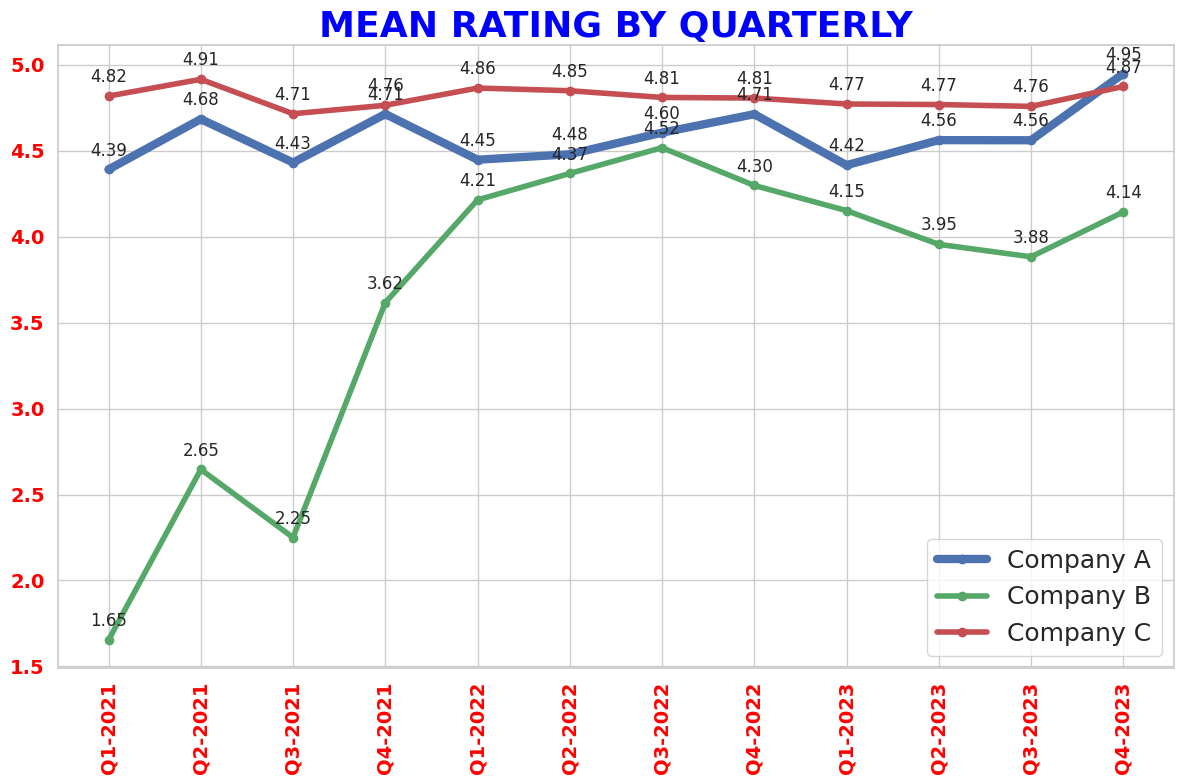

In [156]:
# Create a function to calculate the mean rating by quarter and plot the results
def plot_mean_rating_by_quarter(df, company_name, color, years, linewidth=1.0):
    # Filter data for the specified years
    df_filtered = df[df['Review Date'].dt.year.isin(years)]

    # Calculate the mean rating by quarter
    mean_rating_by_quarter = df_filtered.groupby([df_filtered['Review Date'].dt.year, df_filtered['Review Date'].dt.quarter])['Rating'].mean()
    mean_rating_by_quarter.index = mean_rating_by_quarter.index.map(lambda x: f'Q{x[1]}-{x[0]}')  # Format index as 'QX-YYYY'

    # Create a plot for the mean rating by quarter
    plt.plot(mean_rating_by_quarter.index, mean_rating_by_quarter.values, marker='o', linestyle='-', label=company_name, color=color, linewidth=linewidth)

    # Annotate data points in the quarterly plot
    for x, y in zip(mean_rating_by_quarter.index, mean_rating_by_quarter.values):
        plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Plot mean rating by quarter for each company
plt.figure(figsize=(12, 8))

# Modify the following lines for each company and desired years
plot_mean_rating_by_quarter(sampled_df1, 'Company A', 'b', [2021, 2022, 2023], linewidth=6.0)
plot_mean_rating_by_quarter(sampled_df2, 'Company B', 'g', [2021, 2022, 2023], linewidth=4.0)
plot_mean_rating_by_quarter(sampled_df3, 'Company C', 'r', [2021, 2022, 2023], linewidth=4.0)

# Customize the plot
plt.title('MEAN RATING BY QUARTERLY', fontsize=26, fontweight='bold', color='blue')
plt.grid(True)

# Set legend font size
plt.legend(prop={'size': 18})

# Set xticks and yticks font size and styles
plt.xticks(fontsize=14, fontweight='bold', color='red', rotation=90)
plt.yticks(fontsize=14, fontweight='bold', color='red')


plt.tight_layout()
plt.show()


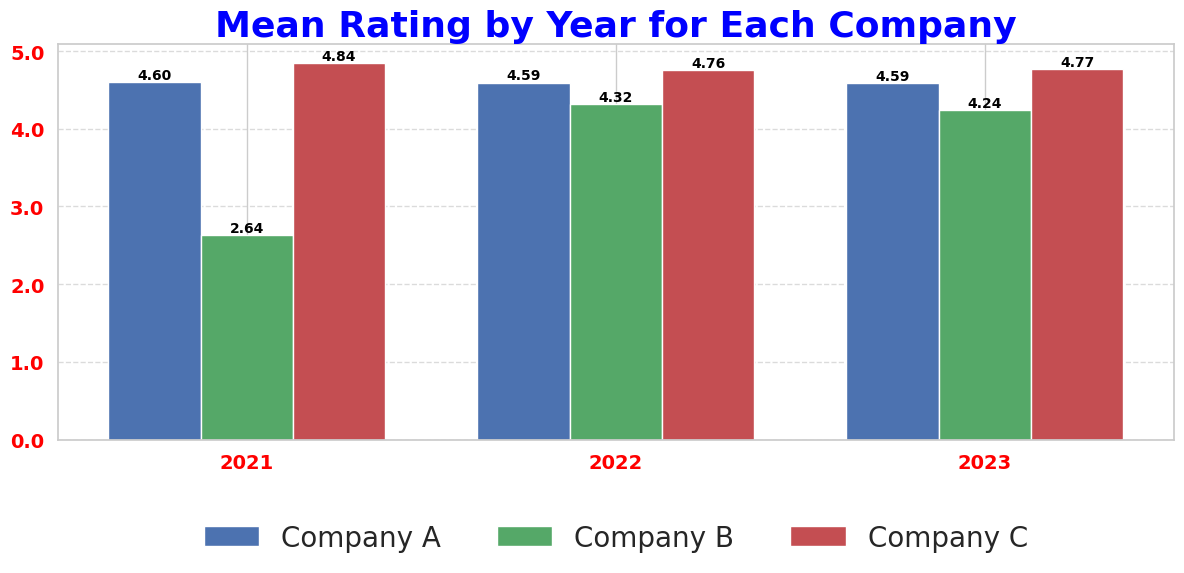

In [38]:
# Create a function to calculate the mean rating by year and plot the results
def plot_mean_rating_by_year(df_list, company_names, colors, years):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Iterate through each DataFrame, company name, and color
    for i, (df, company_name, color) in enumerate(zip(df_list, company_names, colors)):
        # Filter data for the specified years
        df_filtered = df[df['Review Date'].dt.year.isin(years)]

        # Calculate the mean rating by year
        mean_rating_by_year = df_filtered.groupby(df_filtered['Review Date'].dt.year)['Rating'].mean()

        # Create a grouped bar plot for the mean rating by year
        x_pos = np.arange(len(mean_rating_by_year))
        width = 0.25  # Width of each bar

        ax.bar(x_pos + i * width, mean_rating_by_year.values, width=width, label=company_name, color=color)

        # Annotate data points in the yearly plot with bar labels
        for x, y in zip(x_pos + i * width, mean_rating_by_year.values):
            ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    # Customize the plot
    ax.set_title('Mean Rating by Year for Each Company', fontsize=26, fontweight='bold', color='blue')
    ax.set_xticks(x_pos + width)
    ax.set_xticklabels(years, fontsize=14, fontweight='bold', color='red')

    # Add FixedLocator to address the warning
    ax.yaxis.set_major_locator(FixedLocator(ax.get_yticks()))
    ax.set_yticklabels(ax.get_yticks(), fontsize=14, fontweight='bold', color='red')

    # Locate legend at the bottom under the x-axis with a single row
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False, ncol=len(company_names), prop={'size': 20})

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot mean rating by year for each company
plot_mean_rating_by_year([sampled_df1, sampled_df2, sampled_df3], ['Company A', 'Company B', 'Company C'], ['b', 'g', 'r'], [2021, 2022, 2023])

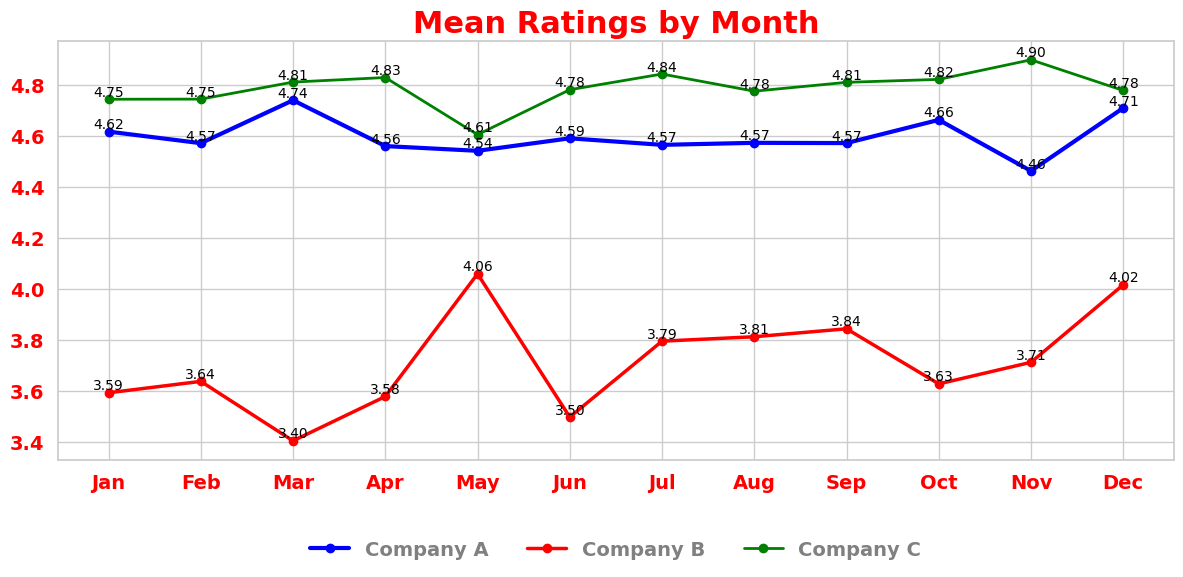

In [59]:
# Create a function to calculate the mean rating by month and plot the results
def plot_mean_rating_by_month(df, company_name, color, linewidth=2.5):
    mean_rating_by_month = df.groupby(df['Review Date'].dt.month)['Rating'].mean()

    # Create a plot for the mean rating by month with enhanced styling
    line, = plt.plot(mean_rating_by_month.index, mean_rating_by_month.values, marker='o', linestyle='-', label=company_name, color=color, linewidth=linewidth)

    # Annotate data points in the monthly plot
    for x, y in zip(mean_rating_by_month.index, mean_rating_by_month.values):
        plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=10, color='black')

    return line  # Return the line for legend

# Plot mean rating by month for each company
plt.figure(figsize=(12, 6))

# Modify the following lines for each company
line1 = plot_mean_rating_by_month(sampled_df1, 'Company A', 'blue', linewidth=3.0)
line2 = plot_mean_rating_by_month(sampled_df2, 'Company B', 'red', linewidth=2.5)
line3 = plot_mean_rating_by_month(sampled_df3, 'Company C', 'green', linewidth=2.0)

# Customize the plot
sns.set(style="whitegrid")
plt.title('Mean Ratings by Month', fontsize=22, fontweight='bold', color='red')

# Set ticker lines
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))  # Place a tick every 1 month

# Set xtick labels
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14, fontweight='bold', color='red')

# Set ytick labels
plt.yticks(fontsize=14, fontweight='bold', color='red')

# Add custom legend
legend = plt.legend(handles=[line1, line2, line3], labels=['Company A', 'Company B', 'Company C'], loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False, prop={'size': 14}, ncol=3)

# Set legend text properties
for text in legend.get_texts():
    text.set_fontweight('bold')
    text.set_fontsize(14)
    text.set_color('grey')

plt.tight_layout()
plt.show()

### DISTRIBUTIONS OF RATINGS

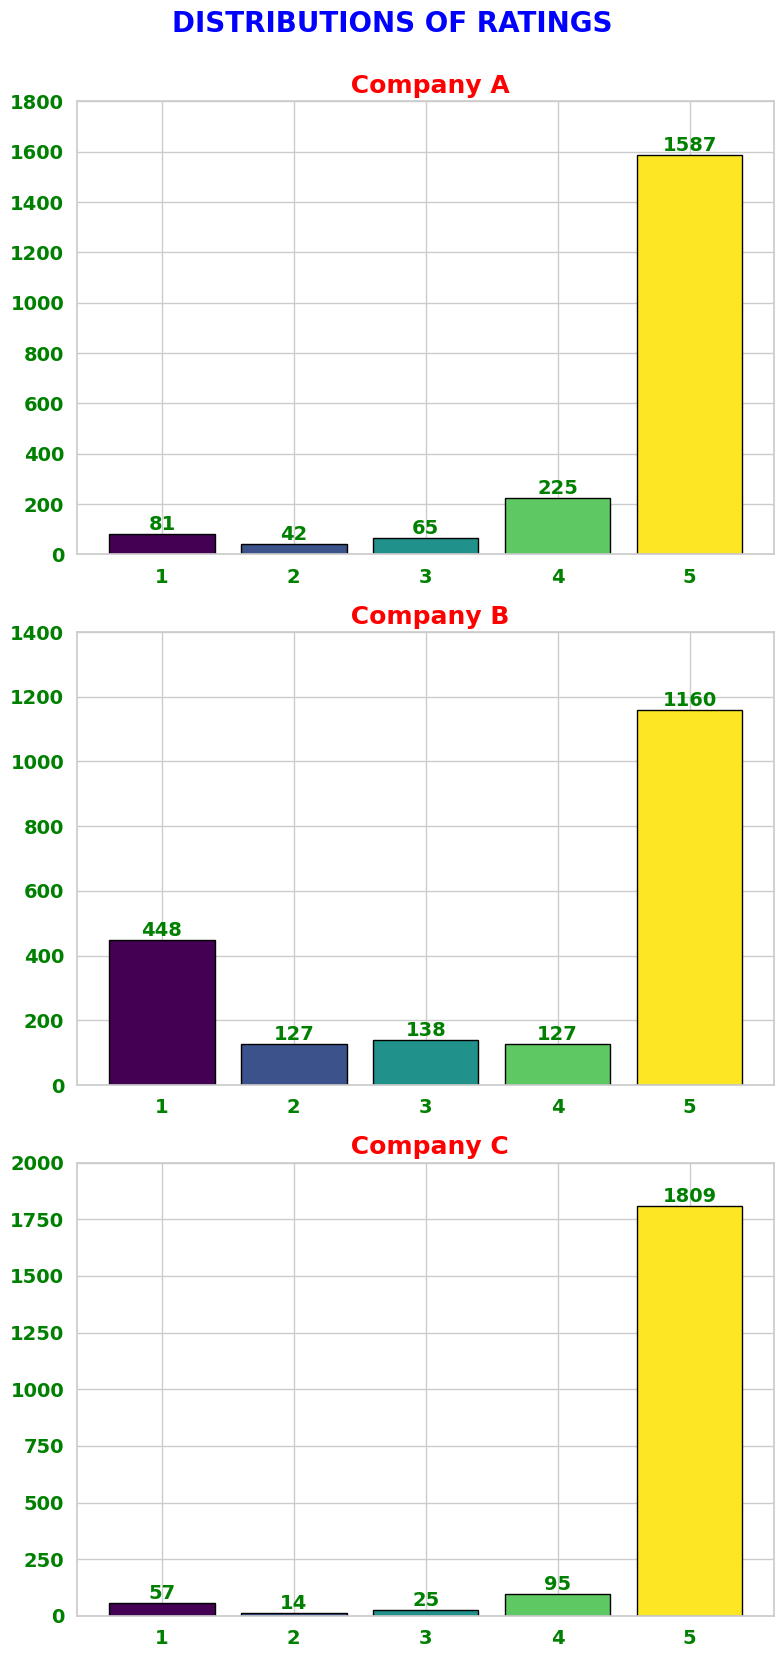

In [60]:
# Set a Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Assuming sampled_df1, sampled_df2, and sampled_df3 are your DataFrames for companies A, B, and C
companies = [sampled_df1, sampled_df2, sampled_df3]
company_names = ['Company A', 'Company B', 'Company C']

# Create subplots for each company's bar plot
fig, axes = plt.subplots(3, 1, figsize=(8, 18))

# Define a color map for ratings 1 to 5
colors = plt.cm.viridis(np.linspace(0, 1, 5))

for i, (company_df, company_name) in enumerate(zip(companies, company_names)):
    # Create a bar plot of ratings for each company with different colors for each bar
    rating_counts = company_df['Rating'].value_counts().sort_index()
    bars = axes[i].bar(rating_counts.index, rating_counts, color=colors, edgecolor='black')

    # Set custom bar labels at the center of each bar
    for bar, color in zip(bars, colors):
        bar_x = bar.get_x() + bar.get_width() / 2
        bar_height = bar.get_height()
        axes[i].text(bar_x, bar_height, str(int(bar_height)), ha='center', va='bottom', fontsize=14, fontweight='bold', color='green')

    # Add title, xlabel, and ylabel with specified font sizes and styles for each subplot
    axes[i].set_title(f' {company_name}', fontsize=18, fontweight='bold', color='red')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

    # Set xticks and yticks font size, style, and remove decimal ticks for x-axis
    axes[i].tick_params(axis='x', which='major', labelsize=14, color='green', width=2, length=6)
    axes[i].set_xticks(range(1, 6))

    # Set yticks font size, style, and remove decimal ticks for y-axis
    axes[i].tick_params(axis='y', which='major', labelsize=14, color='green', width=2, length=6)
    axes[i].set_yticks([int(label) for label in axes[i].get_yticks()])

    # Manually set ytick labels as bold and green
    axes[i].set_yticklabels([f"{int(label)}" for label in axes[i].get_yticks()], fontsize=14, fontweight='bold', color='green')
    axes[i].set_xticklabels([f"{int(label)}" for label in axes[i].get_xticks()], fontsize=14, fontweight='bold', color='green')

# Add an overall title for the entire set of graphs
plt.suptitle('DISTRIBUTIONS OF RATINGS', fontsize=20, fontweight='bold', color='blue', y=0.95)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()